# Load CLIP

In [9]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Traceback (most recent call last):
  File "/usr/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'
Error in sys.excepthook:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/apport_python_hook.py", line 72, in apport_excepthook
    from apport.fileutils import likely_packaged, get_recent_crashes
  File "/usr/lib/python3/dist-packages/apport/__init__.py", line 5, in <module>
    from apport.report import Report
  File "/usr/lib/python3/dist-packages/apport/report.py", line 32, in <module>
    import apport.fileutils
  File "/usr/lib/python3/dist-packages/apport/fileutils.py", line 12, in <module>
    import os, glob, subprocess, os.path, time, pwd, sys, requests_unixsocket
ModuleNotFoundError: No module named 'requests_unixsocket'

Original exception was:
Traceback (most recent call last):
  File "/usr/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No

In [3]:
import numpy as np
import torch
import random
from transformers import CLIPTextModel, CLIPTokenizer
from utils import search_min_sentence_iteration, genetic, PGDattack, get_char_table, train
device = 'cuda'

len_prompt = 5

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)
char_table = get_char_table()

Some weights of the model checkpoint at /home/gaozx/.cache/modelscope/hub/xiaoguailin/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.layer_norm1.bias', 'vision_model.encoder.layers.11.layer_norm2.weight', 'vision_model.encoder.layers.19.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.4.mlp.fc2.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.mlp.fc1.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.18.self_attn.v_proj.bias', 'vision_model.encoder.layers.6.layer_nor

In [ ]:
attack_sentence = "a snake and a young man"

#  Greedy
greedy_sentence = search_min_sentence_iteration(attack_sentence, char_table, len_prompt, 
                                                1, tokenizer=tokenizer, text_encoder=text_encoder)
print("greedy_prompt:",greedy_sentence)

#  Genetic
for i in range(5):
    genetic_prompt = genetic(attack_sentence, char_table, len_prompt, tokenizer=tokenizer, 
                             text_encoder=text_encoder)
    genetic_sentence = attack_sentence + ' ' + genetic_prompt[0][0]
    print("genetic_prompt:",genetic_sentence)
    
#  PGD
for i in range(5):
    max_tensor, loss_list, pgd_prompt, max_loss = train(init_per_sample=1, sentence=attack_sentence, 
                                                        len_prompt=len_prompt, char_list=char_table, 
                                                        model=text_encoder.text_model, iter_num = 100, 
                                                        eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder)  
    pgd_sentence = attack_sentence + ' ' + pgd_prompt
    print("pgd_prompt:",pgd_sentence)

KeyboardInterrupt: 

# Targeted QF Attack

## Step 1: Generate mask

In [ ]:
from utils import object_key
sentence_list = [
    "A black panther lying in a jungle and a young man",
    "A fishing boat on a lake at sunrise and a young man",
    "A tea cup on a saucer with a teapot and a young man",
    "A man playing guitar on a street corner and a young man",
    "A group of flamingos standing in a pond and a young man",
    "A fireflies in a field at dusk and a young man",
    "A train chugging through a countryside and a young man",
    "A butterfly on a colorful flower and a young man",
    "A soccer game being played on a stadium and a young man",
    "A man kayaking down a river through rapids and a young man"
]
mask = object_key(sentence_list, 'and a young man', thres=9, tokenizer=tokenizer, text_encoder=text_encoder)

## Step 2: Generate perturbation prompts

In [ ]:
attack_sentence = "a snake and a young man"
mask = mask.view(-1)

#  Greedy
greedy_sentence = search_min_sentence_iteration(attack_sentence, char_table, len_prompt, 
                                                1, tokenizer=tokenizer, text_encoder=text_encoder,  mask=mask)
print("greedy_prompt:",greedy_sentence)

#  Genetic
for i in range(10):
    genetic_prompt = genetic(attack_sentence, char_table, len_prompt, tokenizer=tokenizer, 
                             text_encoder=text_encoder,  mask=mask)
    genetic_sentence = attack_sentence + ' ' + genetic_prompt[0][0]
    print("genetic_prompt:",genetic_sentence)
    
#  PGD
for i in range(10):
    max_tensor, loss_list, pgd_prompt, max_loss = train(init_per_sample=1, sentence=attack_sentence, 
                                                        len_prompt=len_prompt, char_list=char_table, 
                                                        model=text_encoder.text_model, iter_num = 100, 
                                                        eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder,  mask=mask)  
    pgd_sentence = attack_sentence + ' ' + pgd_prompt
    print("pgd_prompt:",pgd_sentence)

# Evaluation

## Load Stable Diffusion Model v1.4

In [48]:
from diffusers import StableDiffusionPipeline
from torch import autocast
from utils import image_grid
# pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4',torch_dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/gaozx/.virtualenvs/QF-Attack/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


## Generate Images and Show Results

  0%|          | 0/50 [00:00<?, ?it/s]

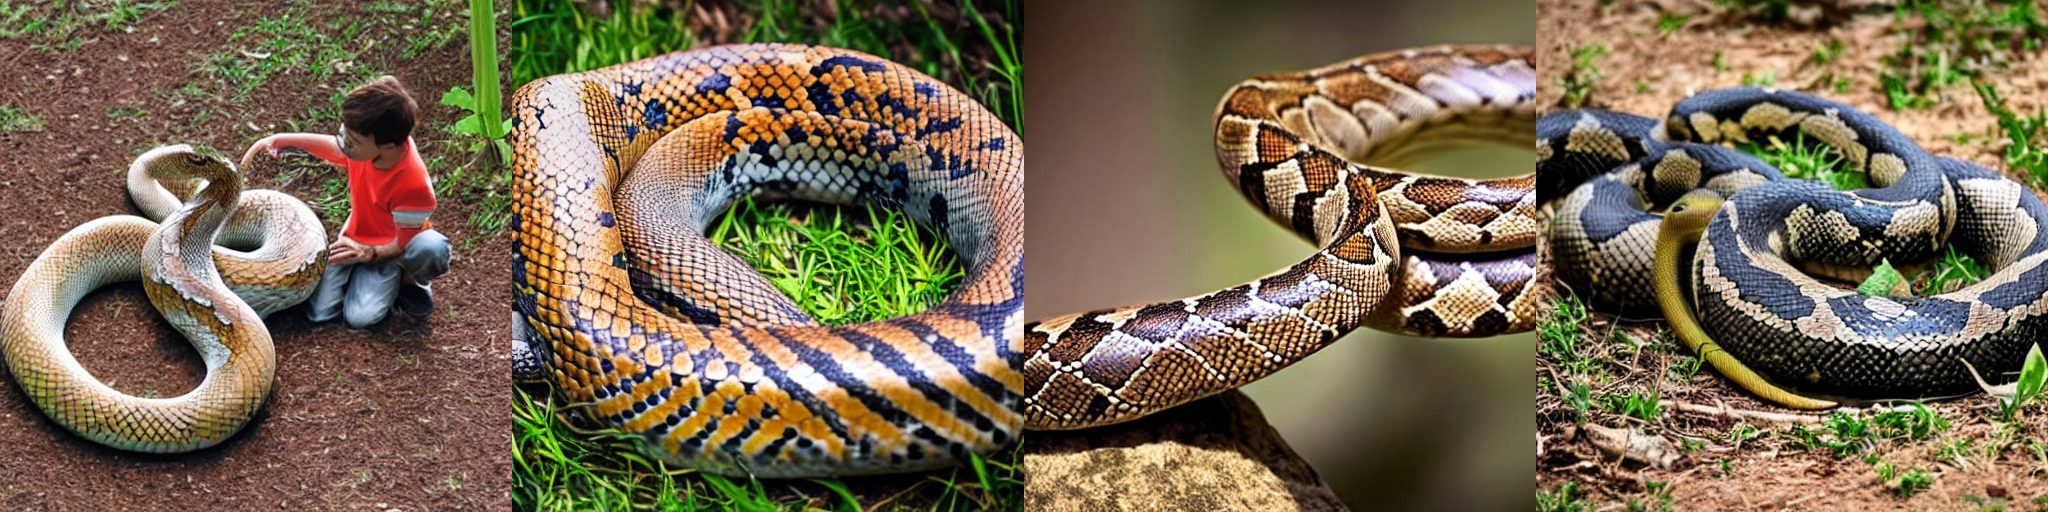

In [53]:
generator = torch.Generator("cuda").manual_seed(27)

original_sentence = 'a snake and a young man'
perturbation_prompt = '-08=*'
sentence = original_sentence + ' ' + perturbation_prompt

num_images = 5
prompt = [sentence] * num_images
with autocast('cuda'):
    images = pipe(prompt, generator=generator, num_inference_steps=50).images

grid = image_grid(images, rows=1, cols=5)
grid


发现 2 个可用的 CUDA 设备
